In [1]:
import urllib2, cStringIO
import json
from PIL import Image
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

import urllib, simplejson
import requests
import StringIO
import time

from dateutil import parser, rrule
from datetime import datetime, time, date
import io

In [ ]:
def getRainfallData(station, day, month, year):
    """
    Function to return a data frame of minute-level weather data for a single Wunderground PWS station.
    
    Args:
        station (string): Station code from the Wunderground website
        day (int): Day of month for which data is requested
        month (int): Month for which data is requested
        year (int): Year for which data is requested
    
    Returns:
        Pandas Dataframe with weather data for specified station and date.
    """
    url = "http://www.wunderground.com/weatherstation/WXDailyHistory.asp?ID={station}&day={day}&month={month}&year={year}&graphspan=day&format=1"
    full_url = url.format(station=station, day=day, month=month, year=year)
    # Request data from wunderground data
    response = requests.get(full_url, headers={'User-agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
    data = response.text
    # remove the excess <br> from the text data
    data = data.replace('<br>', '')
    # Convert to pandas dataframe (fails if issues with weather station)
    try:
        dataframe = pd.read_csv(io.StringIO(data), index_col=False)
        dataframe['station'] = station
    except Exception as e:
        print("Issue with date: {}-{}-{} for station {}".format(day,month,year, station))
        return None
    return dataframe

# Generate a list of all of the dates we want data for
start_date = "2011-11-01"
end_date = "2016-11-16"
start = parser.parse(start_date)
end = parser.parse(end_date)
dates = list(rrule.rrule(rrule.DAILY, dtstart=start, until=end))
 
# Create a list of stations here to download data for
stations = ["IPEFLATR2"]
# Set a backoff time in seconds if a request fails
backoff_time = 10
data = {}

# Gather data for each station in turn and save to CSV.
for station in stations:
    print("Working on {}".format(station))
    data[station] = []
    for date in dates:
        # Print period status update messages
        if date.day % 100 == 0:
            print("Working on date: {} for station {}".format(date, station))
        done = False
        while done == False:
            try:
                weather_data = getRainfallData(station, date.day, date.month, date.year)
                done = True
            except ConnectionError as e:
                # May get rate limited by Wunderground.com, backoff if so.
                print("Got connection error on {}".format(date))
                print("Will retry in {} seconds".format(backoff_time))
                time.sleep(10)
        # Add each processed date to the overall data
        data[station].append(weather_data)
    # Finally combine all of the individual days and output to CSV for analysis.
    pd.concat(data[station]).to_csv("{}_weather.csv".format(station))

In [2]:
station = 'IPEFLATR2' # Belfast
data_raw = pd.read_csv('{}_weather.csv'.format(station))

# Give the variables some friendlier names and convert types as necessary.
data_raw['temp'] = data_raw['TemperatureC'].astype(float)
data_raw['rain'] = data_raw['HourlyPrecipMM'].astype(float)
data_raw['avg_rain'] = data_raw['dailyrainMM'].astype(float)
data_raw['date'] = data_raw['DateUTC'].apply(parser.parse)
data_raw['humidity'] = data_raw['Humidity'].astype(float)
data_raw['wind_direction'] = data_raw['WindDirectionDegrees']
data_raw['wind'] = data_raw['WindSpeedKMH']

# Extract out only the data we need.
data = data_raw.loc[:, ['date', 'temp', 'rain', 'avg_rain', 'humidity', 'wind']]
data

,date,temp,rain,avg_rain,humidity,wind
0,2011-11-01 03:09:00,2.9,0.0,0.0,76.0,2.3
1,2011-11-01 03:24:00,2.4,0.0,1.3,75.0,0.6
2,2011-11-01 03:39:00,2.0,0.0,1.3,76.0,0.0
3,2011-11-01 03:54:00,1.6,0.0,1.3,77.0,0.0
4,2011-11-01 04:09:00,1.0,0.0,1.3,78.0,0.6
5,2011-11-01 04:24:00,0.4,0.0,1.3,80.0,0.0
6,2011-11-01 04:39:00,0.3,0.0,1.3,82.0,0.0
7,2011-11-01 04:54:00,0.4,0.0,1.3,82.0,0.0
8,2011-11-01 05:09:00,0.2,0.0,1.3,83.0,0.0
9,2011-11-01 05:24:00,0.2,0.0,1.3,84.0,0.0


In [3]:
# There's an issue with some stations that record rainfall ~-2500 where data is missing.
if (data['rain'] < -500).sum() > 10:
    print("There's more than 10 messed up days for {}".format(station))
    
# remove the bad samples
data = data[data['rain'] > -500]
 
# Assign the "day" to every date entry
data['day'] = data['date'].apply(lambda x: x.date())
 
# Get the time, day, and hour of each timestamp in the dataset
data['time_of_day'] = data['date'].apply(lambda x: x.time())
data['day_of_week'] = data['date'].apply(lambda x: x.weekday())    
data['hour_of_day'] = data['time_of_day'].apply(lambda x: x.hour)
# Mark the month for each entry so we can look at monthly patterns
data['month'] = data['date'].apply(lambda x: x.month)
data['year'] = data['date'].apply(lambda x: x.year)
 
# Is each time stamp on a working day (Mon-Fri)
data['working_day'] = (data['day_of_week'] >= 0) & (data['day_of_week'] <= 4)
 
# Classify into morning or evening times (assuming travel between 8.15-9am and 5.15-6pm)
data['morning'] = (data['time_of_day'] >= time(8,15)) & (data['time_of_day'] <= time(9,0))
data['evening'] = (data['time_of_day'] >= time(17,15)) & (data['time_of_day'] <= time(18,0))
 
# If there's any rain at all, mark that!
data['raining'] = data['rain'] > 0.0

In [4]:
daily_data = data.groupby(['day']).mean()
daily_data.drop(['hour_of_day','morning','evening','raining'], axis=1, inplace=True)
daily_data.to_csv("{}_weather_daily.csv".format(station))

In [5]:
monthly_data = data.groupby(['year','month']).mean()
monthly_data.drop(['day_of_week', 'hour_of_day', 'working_day','morning','evening','raining'], axis=1, inplace=True)
monthly_data.to_csv("{}_weather_monthly.csv".format(station))

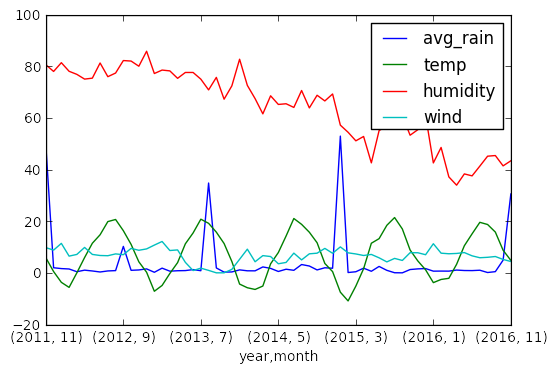

In [7]:
monthly_data[['avg_rain', 'temp', 'humidity','wind']].plot()

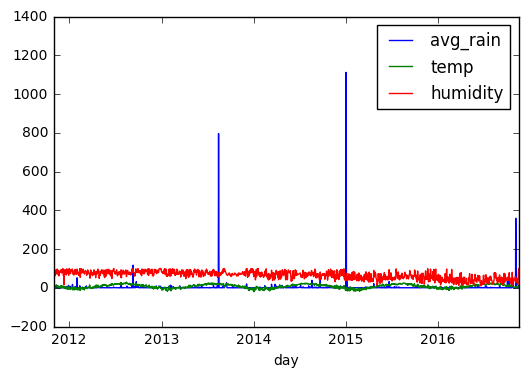

In [7]:
daily_data[['avg_rain', 'temp', 'humidity']].plot()